In [1]:
cd ..

/home/janek/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from sklearn import metrics
from src.reasoner_mod import *
from src.generate import load_dataset, prepare_data
from src.reasoner import *
from src.utils import *
from src.vis import *


In [3]:
seed = 2022
dataset_path = 'local/out/dataset/sub-100.json'
ts = timestr()
train_onto, test_onto, data_tr, data_vl, data_te = load_dataset(dataset_path)


In [4]:
data_tr, data_vl, data_te_tr, data_te_vl, idx_te_te, X_te_te, y_te_te = prepare_data(data_tr, data_vl, data_te, seed)

In [5]:
print(np.mean(data_tr[2]))
print(np.mean(data_vl[2]))
print()
print(np.mean(data_te_tr[2]))
print(np.mean(data_te_vl[2]))
print(np.mean(y_te_te))

0.21857221508533675
0.21258330066640532

0.22166126179245282
0.207749766573296
0.20907114010562286


In [6]:
emb_size = 10
hidden_size = 16
epoch_count = 10
test_epoch_count = 10
batch_size = 32

T.manual_seed(seed)
trained_reasoner = ModifiedReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
encoders = [ModifiedEmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in train_onto]

print(f'created reasoner with {paramcount(trained_reasoner)} parameters')
print(f'created {len(encoders)} encoders with {paramcount(encoders[0])} parameters each')
train_logger = train_mod(data_tr, data_vl, trained_reasoner, encoders, epoch_count=epoch_count,
                          batch_size=batch_size, identities_weight=0.02, identitity_weight_decay=0.93)

created reasoner with 4493 parameters
created 40 encoders with 1270 parameters each
train epoch 00/10 | batch 1704/1703 | loss 0.9017 | val loss 0.6833 | acc 0.7793 | f1 0.1156 | prec 0.3898 | recall 0.0679 | roc auc 0.4598 | pr auc 0.2284 | elapsed 40.15s
train epoch 01/10 | batch 1704/1703 | loss 0.7357 | val loss 0.5271 | acc 0.7970 | f1 0.1575 | prec 0.6694 | recall 0.0892 | roc auc 0.5787 | pr auc 0.3429 | elapsed 79.32s
train epoch 02/10 | batch 1704/1703 | loss 0.5404 | val loss 0.4678 | acc 0.8045 | f1 0.4242 | prec 0.5673 | recall 0.3387 | roc auc 0.7337 | pr auc 0.5068 | elapsed 77.58s
train epoch 03/10 | batch 1704/1703 | loss 0.3979 | val loss 0.4619 | acc 0.8090 | f1 0.5297 | prec 0.5557 | recall 0.5060 | roc auc 0.7828 | pr auc 0.5917 | elapsed 79.71s
train epoch 04/10 | batch 1704/1703 | loss 0.3067 | val loss 0.4740 | acc 0.8117 | f1 0.5731 | prec 0.5532 | recall 0.5945 | roc auc 0.8051 | pr auc 0.6398 | elapsed 78.03s
train epoch 05/10 | batch 1704/1703 | loss 0.2574 |

In [7]:
## --- TESTING
trained_test_encoders = {}
T.manual_seed(seed)
test_logger = TrainingLogger(validate=True, metrics=batch_stats)

for reasoner_name, reasoner in [('trained reasoner', trained_reasoner)]:
    print(reasoner_name)
    T.manual_seed(seed)
    trained_test_encoders[reasoner_name] = test_encoders = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in test_onto]
    train_mod(data_te_tr, data_te_vl, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger)

trained reasoner
train epoch 00/10 | batch 849/848 | loss 0.8862 | val loss 0.9666 | acc 0.6815 | f1 0.4235 | prec 0.3394 | recall 0.5633 | roc auc 0.6807 | pr auc 0.4602 | elapsed 7.57s
train epoch 01/10 | batch 849/848 | loss 0.7701 | val loss 0.8541 | acc 0.7053 | f1 0.4481 | prec 0.3667 | recall 0.5760 | roc auc 0.7084 | pr auc 0.4937 | elapsed 13.16s
train epoch 02/10 | batch 849/848 | loss 0.5528 | val loss 0.7727 | acc 0.7267 | f1 0.4733 | prec 0.3947 | recall 0.5910 | roc auc 0.7330 | pr auc 0.5271 | elapsed 13.80s
train epoch 03/10 | batch 849/848 | loss 0.4039 | val loss 0.7163 | acc 0.7412 | f1 0.4931 | prec 0.4157 | recall 0.6060 | roc auc 0.7528 | pr auc 0.5575 | elapsed 13.04s
train epoch 04/10 | batch 849/848 | loss 0.3076 | val loss 0.6769 | acc 0.7527 | f1 0.5115 | prec 0.4338 | recall 0.6232 | roc auc 0.7682 | pr auc 0.5834 | elapsed 12.73s
train epoch 05/10 | batch 849/848 | loss 0.2467 | val loss 0.6493 | acc 0.7593 | f1 0.5212 | prec 0.4441 | recall 0.6307 | roc au

In [8]:
with T.no_grad():
    # idx_te, X_te, y_te = data_te
    _, _, Y_te_good = eval_batch(trained_reasoner, trained_test_encoders['trained reasoner'], X_te_te, y_te_te, idx_te_te)
    # _, _, Y_te_rand = eval_batch(random_reasoner, trained_test_encoders['random reasoner'], X_te, y_te, idx_te)

local/out/exp/20240715T005325


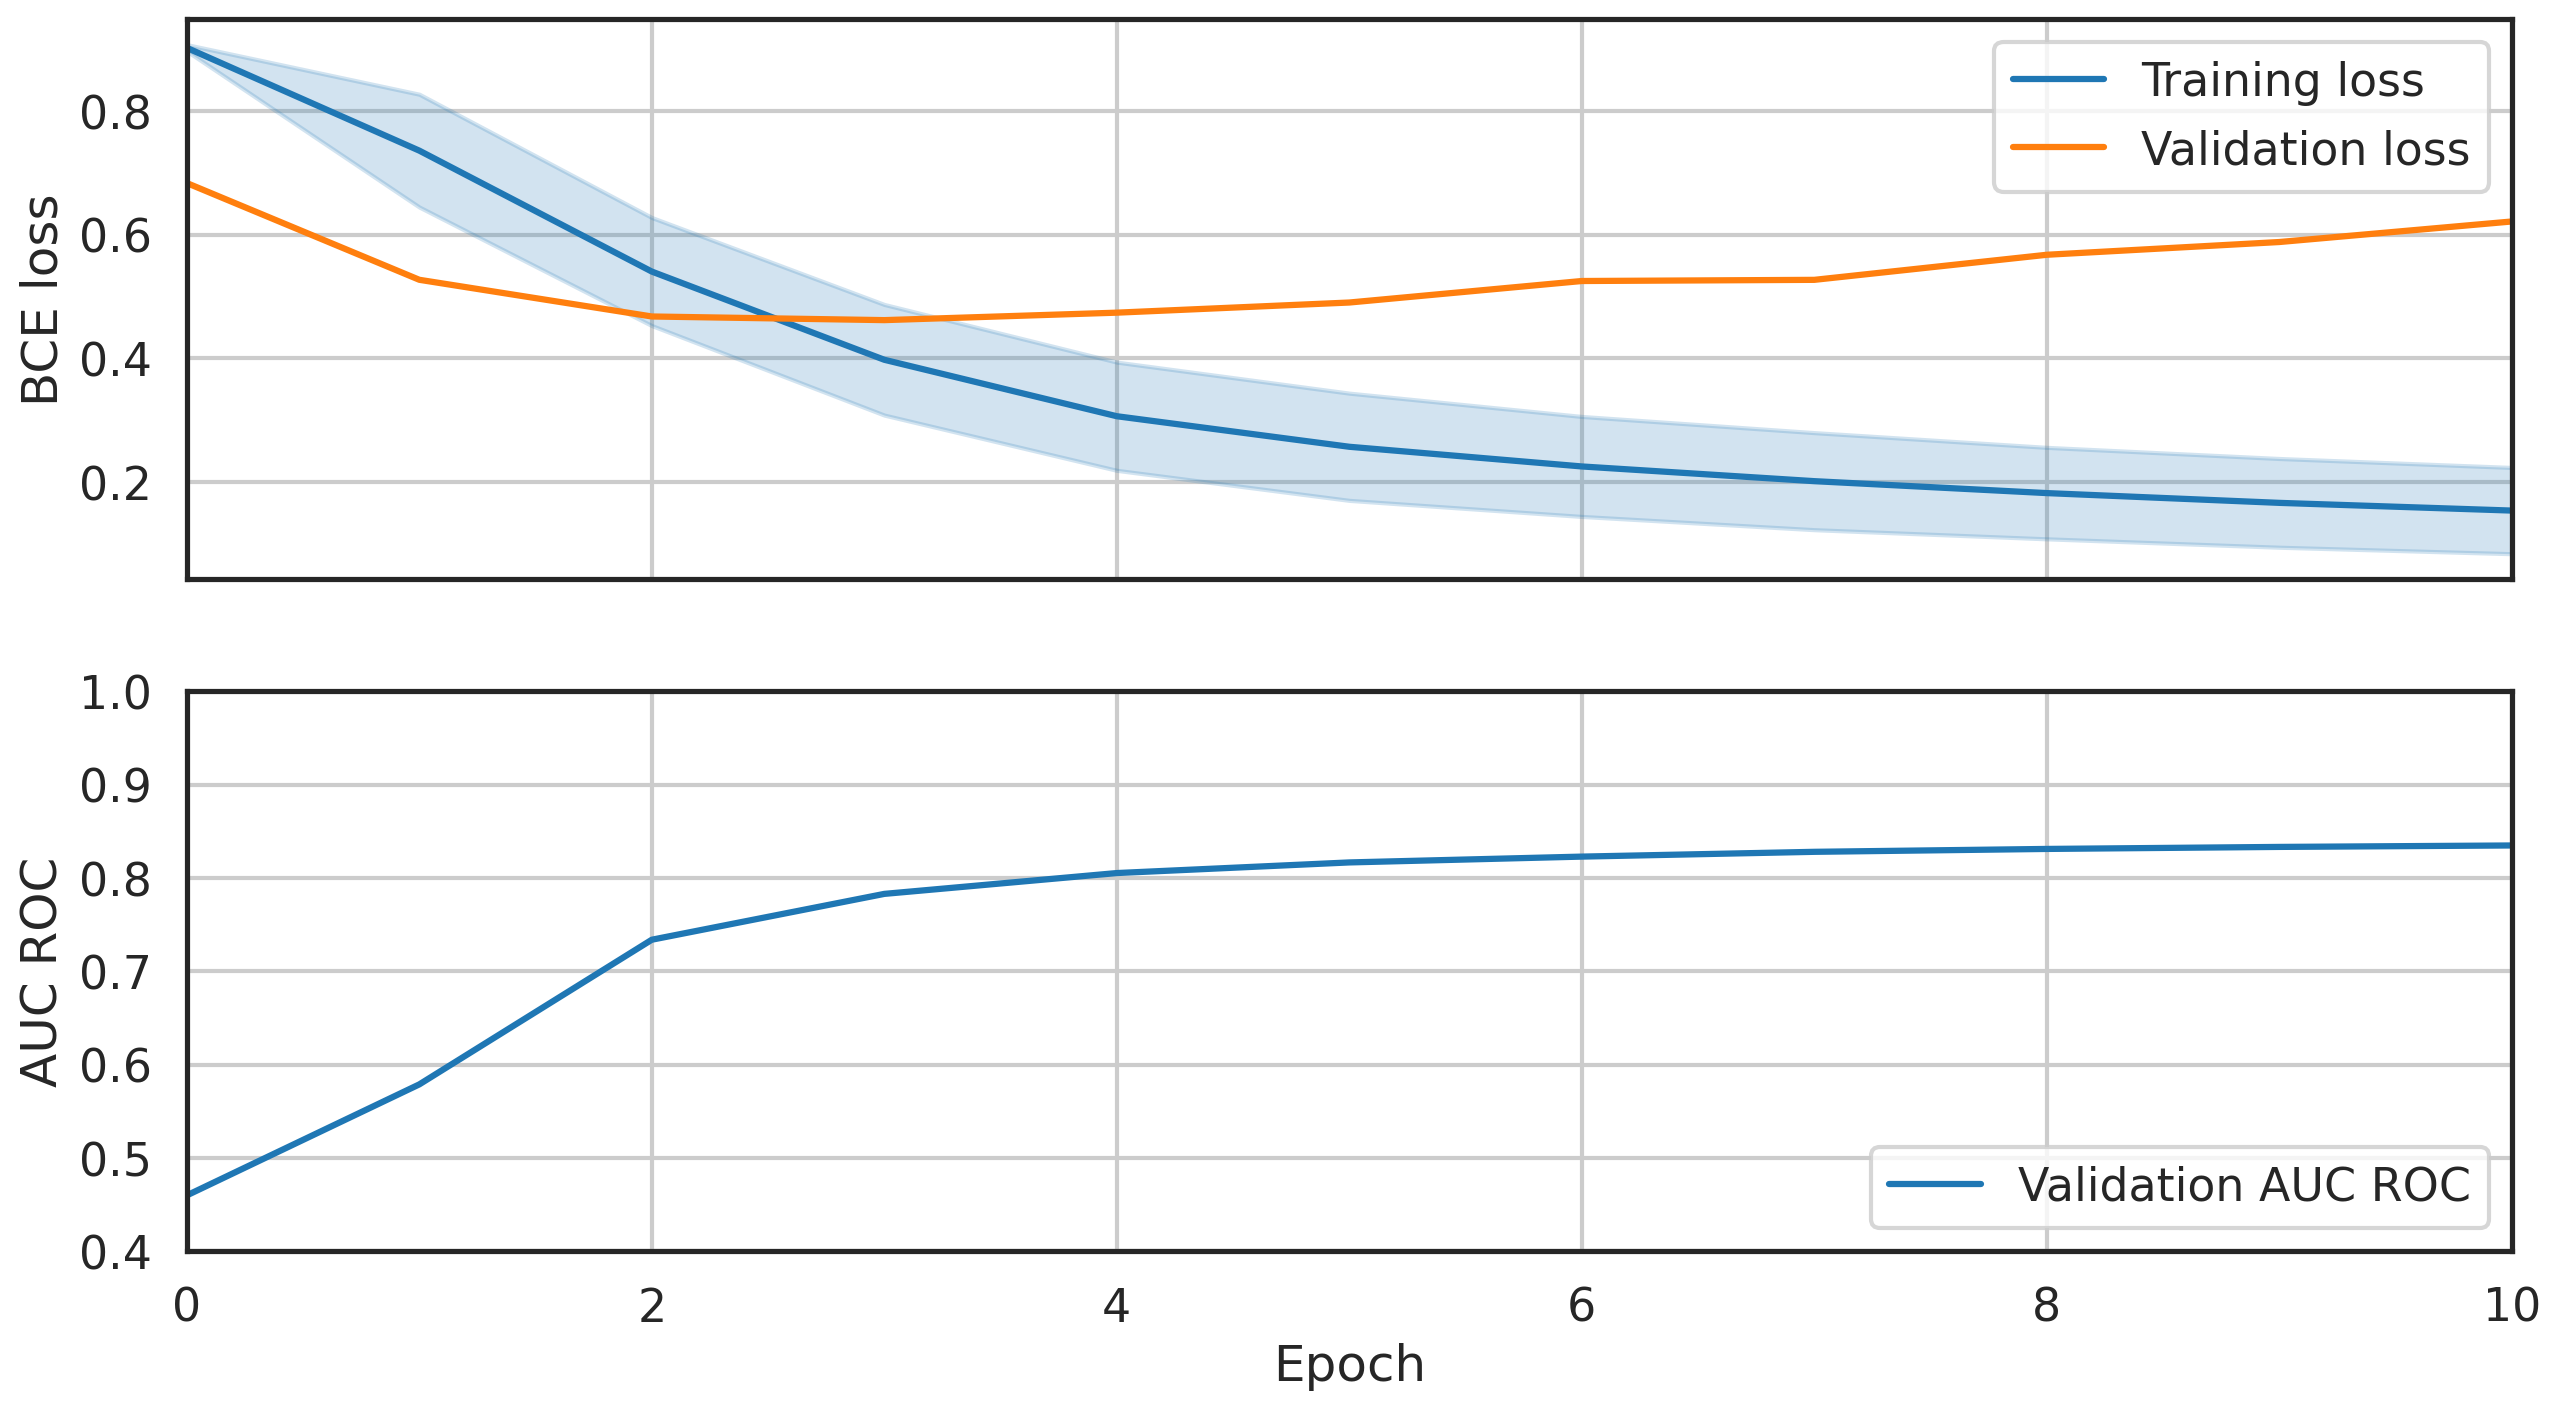

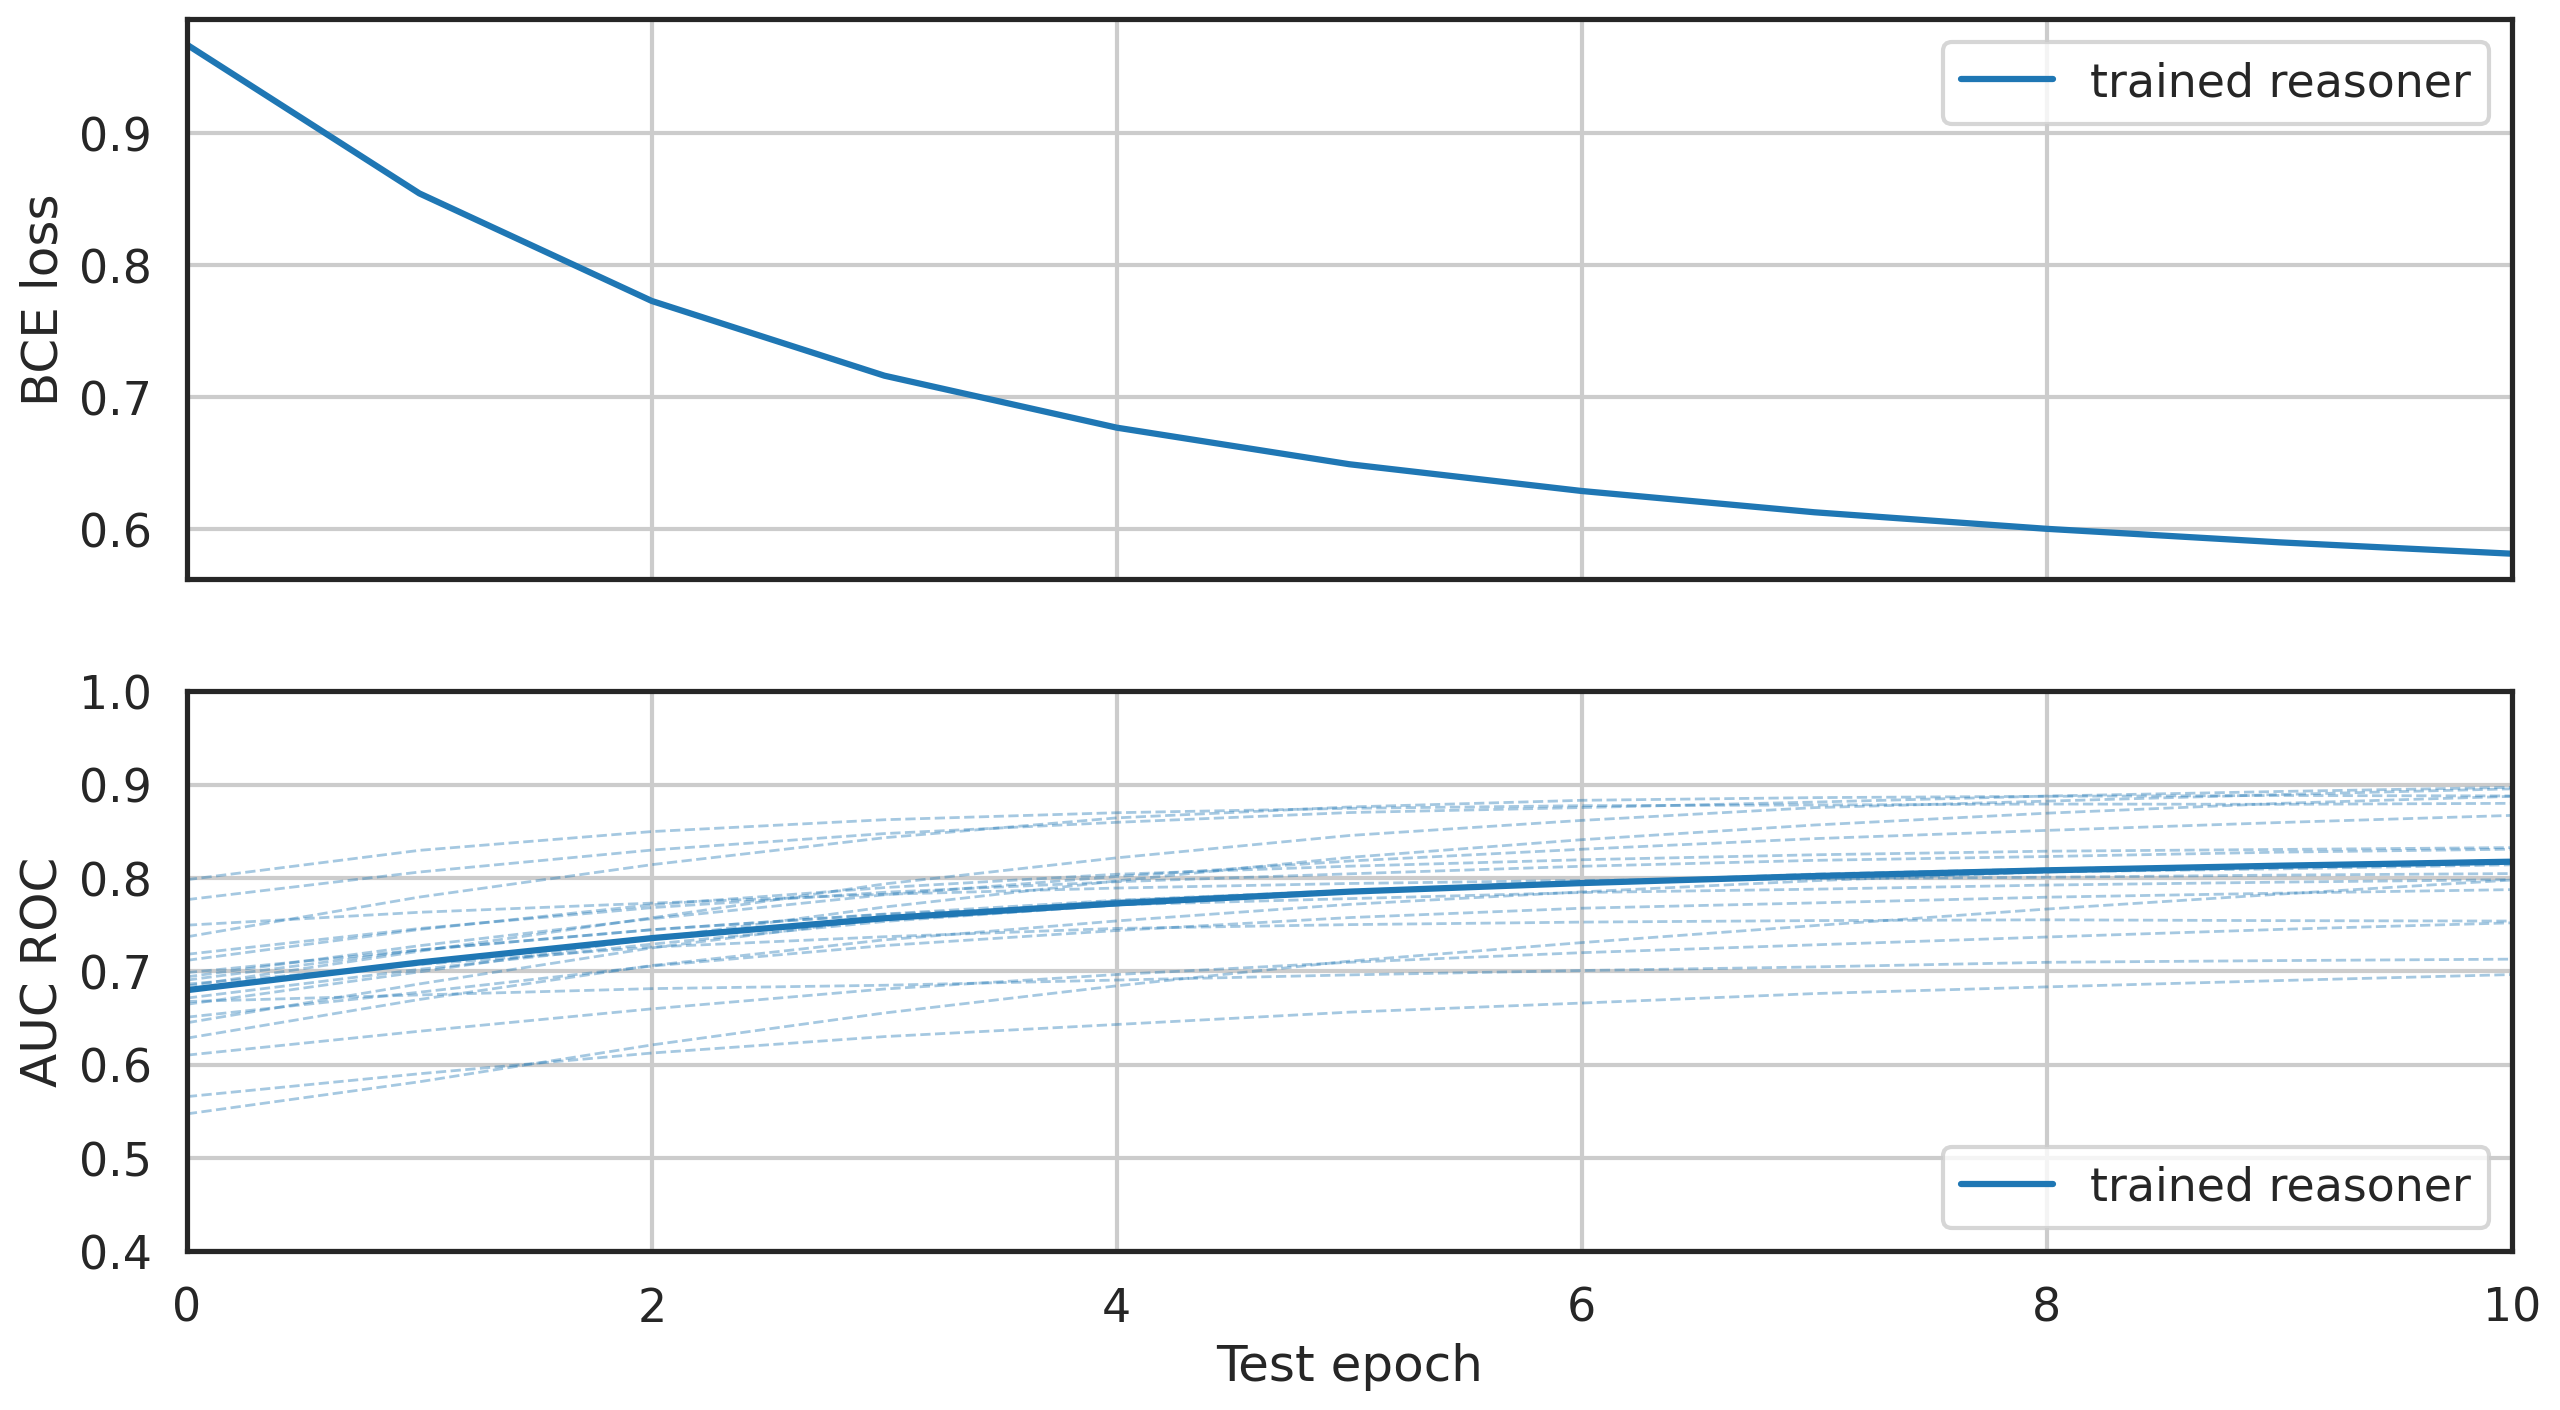

             mean       std     micro
acc      0.804909  0.040406  0.805064
prec     0.527504  0.087483  0.524635
recall   0.725704  0.094517  0.719911
f1       0.604450  0.070280  0.606953
auc_roc  0.838744  0.058577  0.833482
auc_pr   0.718263  0.090090  0.712366


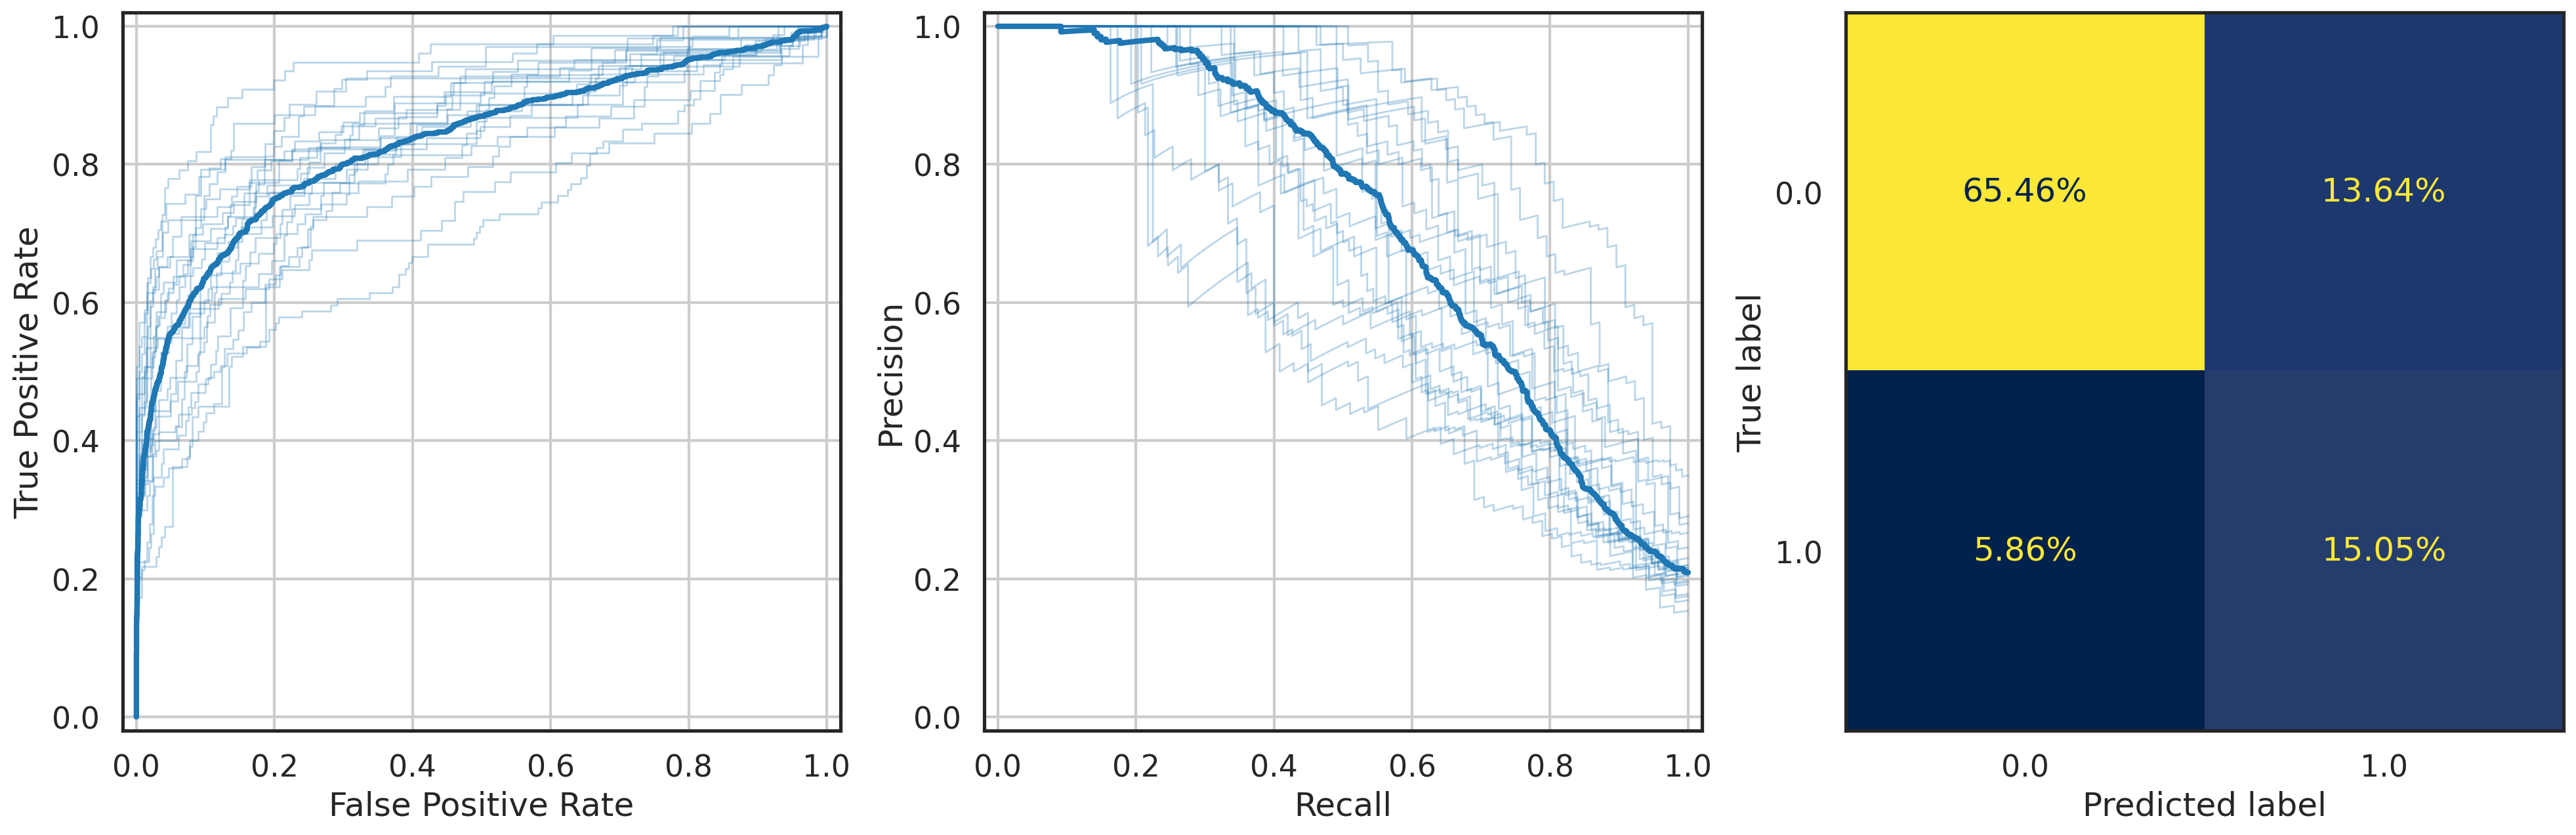

In [9]:
base = 'local/out/exp/' + ts
mkdirp(base)
print(base)

T.save(trained_reasoner.state_dict(), base+'/reasoner.pt')
df_tr = pd.DataFrame(train_logger.history_tr)
df_vl = pd.DataFrame(train_logger.history_vl)
df_tr.to_csv(base+'/train.csv', index=False)
df_vl.to_csv(base+'/valid.csv', index=False)
plot_train_history(df_tr, df_vl, save=base+'/train.png')

test_history_by_onto = pd.DataFrame(test_logger.history_vl_by_onto)
test_history = pd.DataFrame(test_logger.history_vl)
test_results = pd.DataFrame(dict(idx_te=idx_te_te, y_te=y_te_te, Y_te_good=Y_te_good))
test_history.to_csv(base+'/test.csv', index=False)
test_history_by_onto.to_csv(base+'/test-grouped.csv', index=False)
test_results.to_csv(base+'/test-results.csv', index=False)
plot_test_history(test_history, test_history_by_onto)
print(report(test_onto, y_te_te, np.array(Y_te_good), idx_te_te))
# print(report(test_onto, y_te, np.array(Y_te_rand), idx_te))

In [10]:
import random

In [11]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append( F.l1_loss(input, trained_reasoner.and_nn(im(input, input))).item() )


print(input)
print(trained_reasoner.and_nn(im( input, input)))
print(np.mean(losses))

tensor([ 0.1046,  0.1074, -0.1419,  0.0118,  0.2611, -0.0581,  0.1137,  0.0798,
        -0.1034,  0.0284], grad_fn=<SelectBackward0>)
tensor([ 0.1519, -0.1066,  0.1165,  0.0180,  0.1428,  0.0648,  0.0533,  0.0161,
        -0.0963,  0.0267], grad_fn=<AddBackward0>)
0.12790557257831098


In [12]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append(F.l1_loss(trained_reasoner.and_nn(im(trained_reasoner.bot_concept[0], input)), trained_reasoner.bot_concept[0]).item())
print(trained_reasoner.bot_concept[0])
print(trained_reasoner.and_nn(im(trained_reasoner.bot_concept[0], input)))
print(np.mean(losses))

tensor([ 0.5438, -0.8986,  0.3223,  0.3363,  0.3500,  0.1883,  0.7096, -0.6064,
        -0.0627, -0.1887], grad_fn=<SelectBackward0>)
tensor([-0.1383, -0.5802,  0.2963,  0.4871, -0.1682,  0.4883,  0.4637,  0.1903,
        -0.4099, -0.4079], grad_fn=<AddBackward0>)
0.3620877116918564


In [13]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    losses.append(F.l1_loss(trained_reasoner.and_nn(im(trained_reasoner.top_concept[0], input)), input).item())

print(input)
print(trained_reasoner.and_nn(im(trained_reasoner.top_concept[0], input)))
print(np.mean(losses))

tensor([ 0.2308,  0.0548, -0.0620, -0.0079,  0.0171, -0.3048,  0.0350,  0.0726,
        -0.0759, -0.1071], grad_fn=<SelectBackward0>)
tensor([ 0.1313,  0.0234,  0.1497, -0.2007,  0.1515, -0.0604, -0.0673, -0.0884,
         0.0803,  0.0870], grad_fn=<AddBackward0>)
0.14252631478011607


In [14]:
losses = []
for _ in range(20):

    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    output = trained_reasoner.and_nn(im(trained_reasoner.not_nn(input), input))
    losses.append(F.l1_loss(trained_reasoner.bot_concept[0], output).item())

print(trained_reasoner.bot_concept[0])
print(output)
print(np.mean(losses))

tensor([ 0.5438, -0.8986,  0.3223,  0.3363,  0.3500,  0.1883,  0.7096, -0.6064,
        -0.0627, -0.1887], grad_fn=<SelectBackward0>)
tensor([ 0.1171, -0.1303,  0.1718,  0.0430,  0.1476,  0.0395,  0.0308,  0.0053,
        -0.0669, -0.0215], grad_fn=<AddBackward0>)
0.34344803988933564


In [15]:
print(trained_reasoner.bot_concept[0])
output = trained_reasoner.not_nn(trained_reasoner.top_concept[0])
print(output)
print(F.l1_loss(trained_reasoner.bot_concept[0], output))

tensor([ 0.5438, -0.8986,  0.3223,  0.3363,  0.3500,  0.1883,  0.7096, -0.6064,
        -0.0627, -0.1887], grad_fn=<SelectBackward0>)
tensor([ 0.2813, -0.6874,  0.2394,  0.2648,  0.3504,  0.1883,  0.5468, -0.3295,
        -0.0625, -0.0242], grad_fn=<SqueezeBackward3>)
tensor(0.1233, grad_fn=<L1LossBackward0>)


In [16]:
print(trained_reasoner.top_concept[0])
output = trained_reasoner.not_nn(trained_reasoner.bot_concept[0])
print(output)
print(F.l1_loss(trained_reasoner.top_concept[0], output))

tensor([-0.2043, -0.0101, -0.1629, -0.1967, -0.3010, -0.5156,  0.4753, -0.3096,
        -0.2300,  0.6241], grad_fn=<SelectBackward0>)
tensor([-0.2034, -0.0101, -0.1625, -0.1931, -0.3002, -0.5146,  0.4764, -0.3406,
        -0.2300,  0.6240], grad_fn=<SqueezeBackward3>)
tensor(0.0039, grad_fn=<L1LossBackward0>)


In [17]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    input2 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    input3 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    losses.append(F.l1_loss(trained_reasoner.and_nn(im(input1, trained_reasoner.and_nn(im(input2, input3)))), trained_reasoner.and_nn(im(trained_reasoner.and_nn(im(input1, input2)), input3))).item())

print(trained_reasoner.and_nn(im(input1, trained_reasoner.and_nn(im(input2, input3)))))
print(trained_reasoner.and_nn(im(trained_reasoner.and_nn(im(input1, input2)), input3)))
print(np.mean(losses))

tensor([ 0.1714, -0.1620,  0.1356,  0.0559,  0.1344,  0.1130,  0.0601,  0.0318,
        -0.1080, -0.0759], grad_fn=<AddBackward0>)
tensor([ 0.1386, -0.1478,  0.1589,  0.1161,  0.0943,  0.0678,  0.0651,  0.0200,
        -0.1100, -0.1114], grad_fn=<AddBackward0>)
0.0378474036231637


In [18]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    input2 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]

    losses.append( F.l1_loss(trained_reasoner.and_nn(im(input1, input2)), trained_reasoner.and_nn(im(input2, input1))).item())

print(trained_reasoner.and_nn(im(input1, input2)))
print(trained_reasoner.and_nn(im(input2, input1)))

print(np.mean(losses))

tensor([ 0.1953, -0.0158,  0.1297,  0.0085,  0.1753,  0.0258,  0.0243, -0.0308,
        -0.0630,  0.0414], grad_fn=<AddBackward0>)
tensor([ 0.2000, -0.0426,  0.1364, -0.0035,  0.1592,  0.0338,  0.0157, -0.0190,
        -0.0616,  0.0210], grad_fn=<AddBackward0>)
0.027591988677158952


In [19]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append(F.l1_loss(input1, trained_reasoner.and_nn(im(input1, trained_reasoner.top_concept[0]))).item())

print(input1)
print(trained_reasoner.and_nn(im(input1, trained_reasoner.top_concept[0])))

print(np.mean(losses))

tensor([-0.1653, -0.1105, -0.0067,  0.2444,  0.1436, -0.3410, -0.0617,  0.0043,
        -0.1777, -0.0477], grad_fn=<SelectBackward0>)
tensor([ 0.0936, -0.0373,  0.1323, -0.0576,  0.0628, -0.1337, -0.1568,  0.0068,
         0.0713,  0.1386], grad_fn=<AddBackward0>)
0.14428047202527522


In [20]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append( T.sigmoid(trained_reasoner.sub_nn(im(input1, trained_reasoner.top_concept[0]))).item())
print(np.mean(losses))

0.9982241362333297


In [21]:
losses = []
for _ in range(20):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    losses.append(T.sigmoid(trained_reasoner.sub_nn(im(trained_reasoner.bot_concept[0], trained_reasoner.bot_concept[0]))).item())
print(np.mean(losses))

1.0
